# Medical Appointment No Shows
### Why do 20% of patients miss their scheduled appointments?

This is a exploratory data analysis of why people don't show up for their medical appointments. I believe this could be useful to know for a number of reasons. Firstly, those that are more likely to miss their appointments could be sent extra reminders. Secondly, as doctors often overrun on appointments, spacing out the more likely to no-show patients could give the doctors more time to catch up. This as apposed to having a morning packed with patients and running late and then an afternoon where multiple no-shows happen in a row causing the doctor to have wasted time.

In order to make predections I have made a logistic regression model using the data I have been given. This includes: 
 - Finding which parts of the data are most relevant to probability of showing up.
 - Altering the data to find new featurs which have a correlation to showing up.
 - Filtering all these features into just the ones that are most important for the model.
 - Balancing the data as the data currently has many more show-ups than no-shows.
 - Creating the logistic regression model.
 - Testing the model.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from scipy.stats.distributions import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# Exploratory data analysis

**PatientId** - An individual ID number for each patient. Patients who make multiple appointments will retain the same ID number

**AppointmentId** - This in a unique ID number for each appointment, it is not replacated.

**Gender** - Whether the patient is male or female. There are no other possibilities here (no 'non-binary' or 'prefer not to say')

**ScheduledDay** - The date the appointment was made including the time up to seconds.

**AppointmentDay** - The date the appointment is for, not including time.

**Age** - The age of the patient in years.

**Neighbourhood** - The district name that the appointment takes place.

**Scholarship** - Whether the patient qualifies for financial aid. These patients will likely be poor and will be to some degree financially supported by the government.

**Hypertension** - Whether the patient has high blood pressure.

**Diabetes** - Whether the patient has diabetes.

**Alcoholism** - Whether the patient is an alcoholic.

**Handicap** - The degree to which the patient is physically handicapped.

**SMS_received** - Whether the patient has received one or more SMS messages, reminding them of their appointment.

**No-show** - Whether the patient showed up for their appointment. No means they showed up, Yes means they didn't show up.

In [2]:
# Columns 3 and 4 have date information
df = pd.read_csv('medical_no_show.csv', parse_dates=[3,4])
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   PatientId       110527 non-null  float64            
 1   AppointmentID   110527 non-null  int64              
 2   Gender          110527 non-null  object             
 3   ScheduledDay    110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay  110527 non-null  datetime64[ns, UTC]
 5   Age             110527 non-null  int64              
 6   Neighbourhood   110527 non-null  object             
 7   Scholarship     110527 non-null  int64              
 8   Hipertension    110527 non-null  int64              
 9   Diabetes        110527 non-null  int64              
 10  Alcoholism      110527 non-null  int64              
 11  Handcap         110527 non-null  int64              
 12  SMS_received    110527 non-null  int64              
 13  No-show       

In [3]:
# There are some spelling mistakes and some columns have slightly
# misleading names
df.rename(columns = {'Hipertension': 'Hypertension',
                         'Handcap': 'Handicap',
                        'ScheduledDay': 'AppointMade',
                        'AppointmentDay': 'AppointFor'}, inplace = True)

# Appointment ID is unique for each isntance and so can be used for the index
df.set_index('AppointmentID', inplace=True)
# Replace M and F with 1 and 0 to make it easier to test with statistical models
df['Gender'].replace(('M', 'F'), (1, 0), inplace=True)

print(df.info())

# No show is 'Yes' and 'No'. Making these into dummies gives us flexibility in
# how we use the data for statistics
dummies = pd.get_dummies(df['No-show'])
df = pd.concat((df, dummies), axis = 1)

# The overall probability of no show
noshow_prob = df.Yes.sum() / (df.Yes.sum() + df.No.sum())
print(noshow_prob)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 5642903 to 5629448
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   PatientId      110527 non-null  float64            
 1   Gender         110527 non-null  int64              
 2   AppointMade    110527 non-null  datetime64[ns, UTC]
 3   AppointFor     110527 non-null  datetime64[ns, UTC]
 4   Age            110527 non-null  int64              
 5   Neighbourhood  110527 non-null  object             
 6   Scholarship    110527 non-null  int64              
 7   Hypertension   110527 non-null  int64              
 8   Diabetes       110527 non-null  int64              
 9   Alcoholism     110527 non-null  int64              
 10  Handicap       110527 non-null  int64              
 11  SMS_received   110527 non-null  int64              
 12  No-show        110527 non-null  object             
dtypes: datetime64[ns, UTC]

Our classes are imbalanced with a 20.2% chance of no show and 79.8% chance to show up.

In [4]:
print(df.describe())

          PatientId         Gender            Age    Scholarship  \
count  1.105270e+05  110527.000000  110527.000000  110527.000000   
mean   1.474963e+14       0.350023      37.088874       0.098266   
std    2.560949e+14       0.476979      23.110205       0.297675   
min    3.921784e+04       0.000000      -1.000000       0.000000   
25%    4.172614e+12       0.000000      18.000000       0.000000   
50%    3.173184e+13       0.000000      37.000000       0.000000   
75%    9.439172e+13       1.000000      55.000000       0.000000   
max    9.999816e+14       1.000000     115.000000       1.000000   

        Hypertension       Diabetes     Alcoholism       Handicap  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.197246       0.071865       0.030400       0.022248   
std         0.397921       0.258265       0.171686       0.161543   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       

The minimum age is -1 and the maximum is 115. The maximum being that high probably means there are a number of ages with very little sample size so we will likely put the age feature into bins at a later point. But for now lets remove and ages below 0

### Age

Age
0      3539
1      2273
2      1618
3      1513
4      1299
       ... 
98        6
99        1
100       4
102       2
115       5
Name: PatientId, Length: 103, dtype: int64


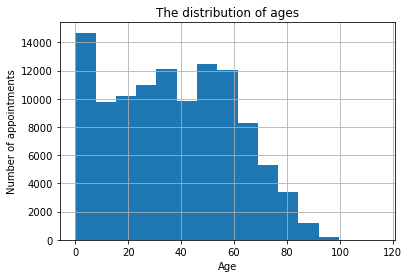

In [5]:
# Removing entries where the age is less than 0
df = df.loc[df['Age'] >= 0]
# showing the smallest and largest age categories and how many are in each
print(df.groupby('Age')['PatientId'].count())

# Creating a simple histogram to show distribution
df['Age'].hist(bins = 15)
plt.title('The distribution of ages')
plt.xlabel('Age')
plt.ylabel('Number of appointments')
plt.show()

We can see that age goes up to a maximum of 115, although many of the ages at the upper end have very few samples.

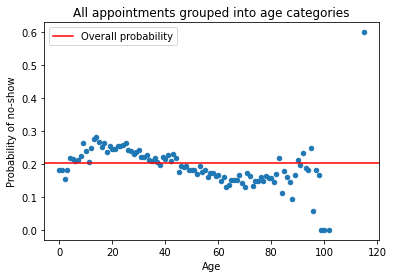

In [6]:
# GRouping all appointments by age and then calculating the probability of 
# no show for each age
df_age = pd.concat([df.groupby('Age')['No'].sum(), df.groupby('Age')['Yes'].sum()], axis=1)
df_age['Probability of no-show'] = df_age['Yes'] / (df_age['No'] + df_age['Yes'])
df_age.reset_index(inplace=True)
df_age.head()

# Plotting the probabiltiy of no-show by age
df_age.plot(kind='scatter', x='Age', y='Probability of no-show')
# Creating a line at the overall probability
plt.axhline(noshow_prob, c='r', label='Overall probability')
plt.legend()
plt.title('All appointments grouped into age categories')
plt.show()

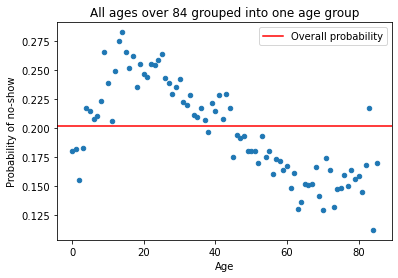

In [7]:
# reducing all ages over 85 to 85
max_age = 85
df['Age'][df['Age'] >= max_age] = max_age

# Calculating the new probabilities with all ages capped at 85
df_age = pd.concat([df.groupby('Age')['No'].sum(), df.groupby('Age')['Yes'].sum()], axis=1)
df_age['Probability of no-show'] = df_age['Yes'] / (df_age['No'] + df_age['Yes'])
df_age.reset_index(inplace=True)

# PLotting the new probabilities with all ages capped at 85
df_age.plot(kind='scatter', x='Age', y='Probability of no-show')
plt.axhline(noshow_prob, c='r', label='Overall probability')
plt.legend()
plt.title('All ages over 84 grouped into one age group')
plt.show()

It looks like there is a polynomial relationship with age and probability of showing up for a medical appointment. To me it looks like we would be better using polynomial terms rather than bins for the 'Age' feature and we just reduce all values above 85 down to 85. It is around 85 that there are too few data points per year to give accurate probabilities.

### Categorical features

Correlation for Handicap is -0.006076846582439237
Correlation for handicap - 0 is 0.007281409275944209
Correlation for handicap - 1 is -0.007757374294273439
Correlation for handicap - 2 is 2.550375494778824e-05
Correlation for handicap - 3 is 0.0007790371412119528
Correlation for handicap - 4 is 0.0017053037239939887


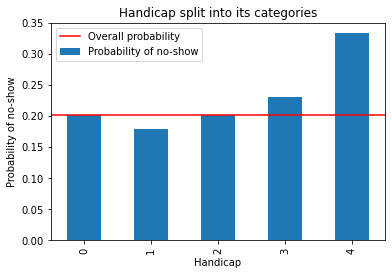

In [8]:
print('Correlation for Handicap is', df['Handicap'].corr(df['Yes']))

# splitting the handicap feature into dummies and loking for a correlaion with no-show
# for each of them in turn
dummies_hand = pd.get_dummies(df['Handicap'])
for dum in dummies_hand.columns:
    cor = dummies_hand[dum].corr(df['Yes'])
    print(f'Correlation for handicap - {dum} is {cor}')

# Grouping all appointments by patient handicap and calculating the probability
# of no-show for each of them
df_hand = pd.concat([df.groupby('Handicap')['No'].sum(), df.groupby('Handicap')['Yes'].sum()], axis=1)
df_hand['Probability of no-show'] = df_hand['Yes'] / (df_hand['No'] + df_hand['Yes'])
df_hand.reset_index(inplace=True)

# Plotting the probability of no-show for each of the 5 handicap categories
df_hand.plot(kind='bar', x='Handicap', y='Probability of no-show')
plt.axhline(noshow_prob, c='r', label='Overall probability')
plt.legend()
plt.title('Handicap split into its categories')
plt.ylabel('Probability of no-show')
plt.show()

There isn't an overall trend, so to keep this feature intact would not work for a linear relationship. Maybe the best way to look at the effect of handicap on no-show probability would be to only include dummy columns for handicap 1, 3 and 4.

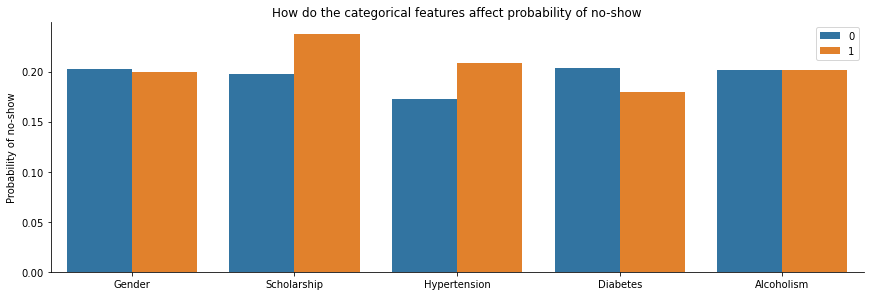

In [9]:
# This is a list of all the binary features
binary_cats = ['Gender', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism']

# Calculating the probablity of no show for both categories in each binary feature
df_probs = pd.DataFrame()
for cat in binary_cats:
    probs = []
    for unique in df[cat].unique():
        probs.append(df[(df[cat] == unique) & (df['Yes'] == 1)].shape[0] / df[df[cat] == unique].shape[0])
    df_probs[cat] = probs

# Altering the df to make it easy to plot. We need a row for each bar
# We need a column with the probability, a column for the feature and a 
# column for the category
df_probs = df_probs.T
df_probs2 = pd.melt(df_probs.reset_index(), id_vars='index')

g = sns.factorplot(x='index', y="value", hue="variable", data=df_probs2, size=4,
                     aspect=3, kind="bar", legend=False)
plt.legend()
plt.title('How do the categorical features affect probability of no-show')
plt.ylabel('Probability of no-show')
plt.xlabel('')
plt.show()

We can see that at least for 'Scholarship', Hypertension' and 'Diabetes' there is some relationship with no-show probability. 'Gender' and 'Alcoholism' clearly have almost no link.

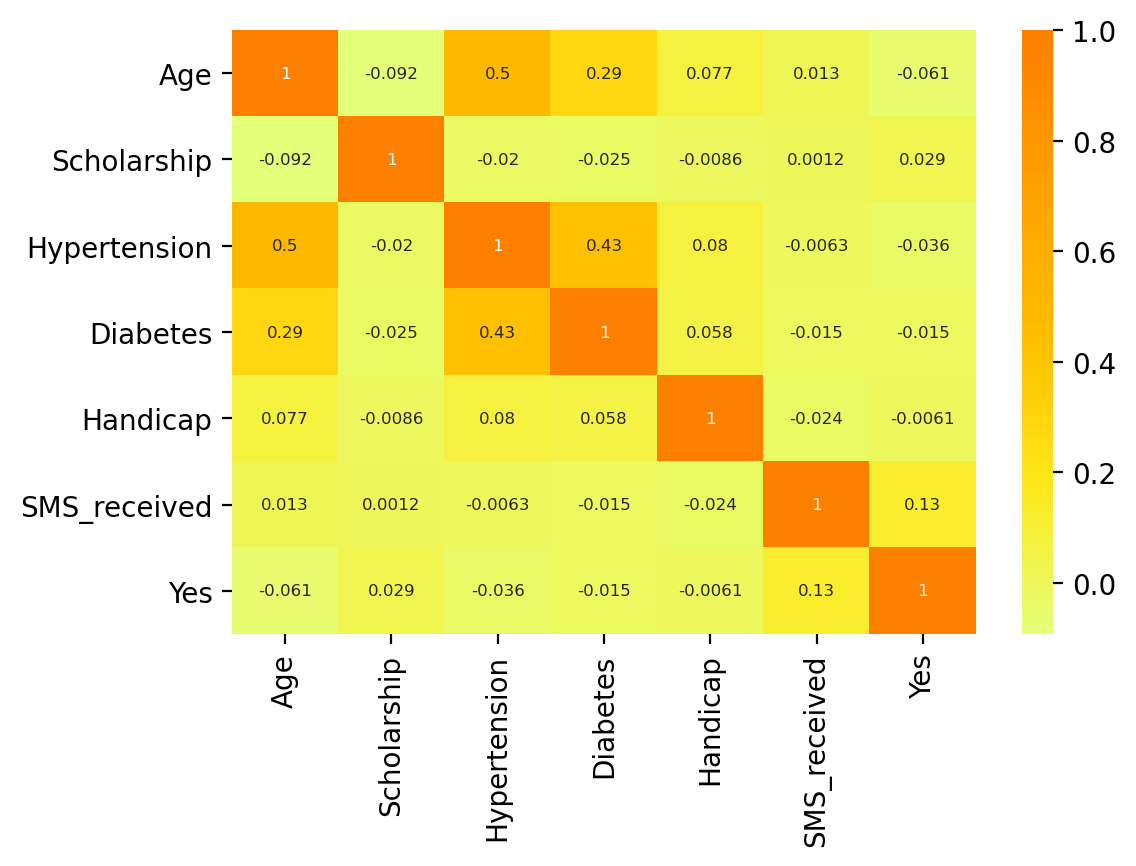

In [10]:
# Creating a Pearson correlation matrix to visualise correlations between features
corr_cats = ['Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Handicap', 'SMS_received', 'Yes']
df_corr = df.loc[:, corr_cats]
corr = df_corr.corr()
fig, ax = plt.subplots(dpi=200)
sns.heatmap(corr, cmap = 'Wistia', annot= True, ax=ax, annot_kws={"size": 6})
plt.show()

There doesn't seem to be any parameters which have a strong correlation with showing up for an appointment. For many of these features, the correlation is stronger with age than with no-show. I would be wary of using these as parameters for the logistic regression. However, there is a clear correlation with receiving an SMS.

### Neighbourhood

The first thing to note in the neighbourhood category is that it has a large number of different categories. Secondly, some of the smaller categories have very few samples in them. We will have to deal with these two things if we want to extract meaningful information from this feature.

In [11]:
# How many differnet neighbourhoods are there
neigh_size = df['Neighbourhood'].unique().size
neighbourhoods = df['Neighbourhood'].unique()

# Visualising the neighbourhood feature and each of its categories
print(df['Neighbourhood'].unique())
print(f'\nNumber of neighbourhoods - {neigh_size} \n')
print(f'The overall probability of a no show is {noshow_prob}')

# Calculating the probability of no-show for each neighbourhood
df_neigh = pd.concat([df.groupby('Neighbourhood')['No'].sum(), df.groupby('Neighbourhood')['Yes'].sum()], axis=1)
df_neigh['Total'] = df_neigh.sum(axis=1)
df_neigh['Probability of no-show'] = df_neigh['Yes'] / df_neigh['Total']
df_neigh.sort_values('Total', ascending=False, inplace=True)
print(df_neigh)

['JARDIM DA PENHA' 'MATA DA PRAIA' 'PONTAL DE CAMBURI' 'REPÚBLICA'
 'GOIABEIRAS' 'ANDORINHAS' 'CONQUISTA' 'NOVA PALESTINA' 'DA PENHA'
 'TABUAZEIRO' 'BENTO FERREIRA' 'SÃO PEDRO' 'SANTA MARTHA' 'SÃO CRISTÓVÃO'
 'MARUÍPE' 'GRANDE VITÓRIA' 'SÃO BENEDITO' 'ILHA DAS CAIEIRAS'
 'SANTO ANDRÉ' 'SOLON BORGES' 'BONFIM' 'JARDIM CAMBURI' 'MARIA ORTIZ'
 'JABOUR' 'ANTÔNIO HONÓRIO' 'RESISTÊNCIA' 'ILHA DE SANTA MARIA'
 'JUCUTUQUARA' 'MONTE BELO' 'MÁRIO CYPRESTE' 'SANTO ANTÔNIO' 'BELA VISTA'
 'PRAIA DO SUÁ' 'SANTA HELENA' 'ITARARÉ' 'INHANGUETÁ' 'UNIVERSITÁRIO'
 'SÃO JOSÉ' 'REDENÇÃO' 'SANTA CLARA' 'CENTRO' 'PARQUE MOSCOSO'
 'DO MOSCOSO' 'SANTOS DUMONT' 'CARATOÍRA' 'ARIOVALDO FAVALESSA'
 'ILHA DO FRADE' 'GURIGICA' 'JOANA D´ARC' 'CONSOLAÇÃO' 'PRAIA DO CANTO'
 'BOA VISTA' 'MORADA DE CAMBURI' 'SANTA LUÍZA' 'SANTA LÚCIA'
 'BARRO VERMELHO' 'ESTRELINHA' 'FORTE SÃO JOÃO' 'FONTE GRANDE'
 'ENSEADA DO SUÁ' 'SANTOS REIS' 'PIEDADE' 'JESUS DE NAZARETH'
 'SANTA TEREZA' 'CRUZAMENTO' 'ILHA DO PRÍNCIPE' 'ROMÃO' 'COMDUSA'


In [12]:
# Setting our minimum sample size for a category within neighbourhood
small_samp_size = 50

print(f'The number of districts with sample size above our threshold of {small_samp_size} is -')
print(df_neigh[df_neigh['Total'] >= small_samp_size].shape[0])
print(f'The number of districts with sample size below our threshold of {small_samp_size} is -')
print(df_neigh[df_neigh['Total'] < small_samp_size].shape[0])
print('The number of rejected samples is then')
print(df_neigh[df_neigh['Total'] < small_samp_size]['Total'].sum())

# Removing instances that come from categories with not enough samples
df_neigh = df_neigh[df_neigh['Total'] >= small_samp_size]

The number of districts with sample size above our threshold of 50 is -
76
The number of districts with sample size below our threshold of 50 is -
5
The number of rejected samples is then
56.0


The smallest expected frequency should be above 5. At 20% chance of no-show there should be at least 25 from each district to expect 5 no-shows. We will double this just to be safe. The number of districts cut is not large at onle 5 and the number of samples wihtout neighbourhood information is only 56.

In [13]:
# Calculating the chi-squared for neighbourhood as a feature in its entirety
# This is extracting the necessary data
neigh_vals = df_neigh.loc[:, ['Yes', 'No']].values
chi2_stat, p_val, dof, ex = stats.chi2_contingency(neigh_vals)
print(f'Chi squared value is {chi2_stat} and the p-value is {p_val}')

Chi squared value is 480.5172010361685 and the p-value is 1.8612890706511266e-60


This shows that there is certainly a statistical significance in the neghbourhood category and that it could give us some indication of likelihood of a no-show. The p-value is very small, way below any statistical limits (0.01 or 0.05).

In [14]:
# Calculating the expected Yes and No values by the number of instances
# within each category timesed by the overall probability of no-show
df_neigh['Exp_yes'] = df_neigh['Total'] * noshow_prob
df_neigh['Exp_no'] = df_neigh['Total'] - df_neigh['Exp_yes']
# Reordering the column titles so it goes No then Yes and also Exp_no and then Exp_yes
columns_titles = ['No', 'Yes', 'Probability of no-show', 'Exp_no','Exp_yes']
df_neigh=df_neigh.reindex(columns=columns_titles)

print(df_neigh)

                       No     Yes  Probability of no-show       Exp_no  \
Neighbourhood                                                            
JARDIM CAMBURI     6252.0  1465.0                0.189841  6158.686439   
MARIA ORTIZ        4586.0  1219.0                0.209991  4632.781492   
RESISTÊNCIA        3525.0   906.0                0.204469  3536.236829   
JARDIM DA PENHA    3246.0   631.0                0.162755  3094.107467   
ITARARÉ            2591.0   923.0                0.262664  2804.408986   
...                   ...     ...                     ...          ...   
UNIVERSITÁRIO       120.0    32.0                0.210526   121.306251   
SEGURANÇA DO LAR    117.0    28.0                0.193103   115.719779   
NAZARETH            106.0    29.0                0.214815   107.739104   
MORADA DE CAMBURI    80.0    16.0                0.166667    76.614474   
PONTAL DE CAMBURI    57.0    12.0                0.173913    55.066653   

                       Exp_yes  
Neig

In [15]:
def chi_squared(row):
    # Extracting the observed and expected values form each row
    observed = row[['No', 'Yes']].values
    expected = row[['Exp_no', 'Exp_yes']].values
    
    # Chi squared on this 1x2 set of values
    chi = expected - observed
    chi = chi * chi
    chi = chi / expected
    chi = np.sum(chi)
    
    # calculating the p-value with 1 degree of freedom (dof)
    pval = chi2.sf(chi,1)
    
    return pd.Series({'chi': chi, 'pvalue': pval})

# Applying the chi squared function to each row of a matrix
chi_results = df_neigh.apply(chi_squared, axis = 1)
print(chi_results)

                         chi        pvalue
Neighbourhood                             
JARDIM CAMBURI      7.001564  8.143852e-03
MARIA ORTIZ         2.339376  1.261401e-01
RESISTÊNCIA         0.176823  6.741175e-01
JARDIM DA PENHA    36.925901  1.227050e-09
ITARARÉ            80.422525  3.023291e-19
...                      ...           ...
UNIVERSITÁRIO       0.069657  7.918371e-01
SEGURANÇA DO LAR    0.070138  7.911353e-01
NAZARETH            0.139018  7.092590e-01
MORADA DE CAMBURI   0.740858  3.893861e-01
PONTAL DE CAMBURI   0.336143  5.620639e-01

[76 rows x 2 columns]


We can use this function to give us the statistical significance of each neighbourhood individually. The chisquared method tests the null hypothesis 'there is no relationship with this neighbourhood and the chance of showing up for an appointment'. A very low score means we can reject it and accept the alternative hypothesis 'there is a relationship with this neighbourhood and showing up for a medical appointment'. Values of 0.05 and 0.01 depending on how strict you want to be are often chosen as being low enough to reject the null hypothesis

We want to find find which are the most statistically significant neighbourhoods and only include them in the model to keep things as simple as possible without losing important information.

In [16]:
# making a list of neighbourhoods with a chi squared value of under 0.05
neigh_keep = chi_results[chi_results['pvalue'] <= 0.05].index.tolist()
print('Number of kept neighbourhoods with p-val under 0.05 is -', len(neigh_keep))
print(neigh_keep)

# making a list of neighbourhoods with a chi squared value of under 0.01
neigh_keep2 = chi_results[chi_results['pvalue'] <= 0.01].index.tolist()
print('Number of kept neighbourhoods with p-val under 0.01 is -', len(neigh_keep2))

Number of kept neighbourhoods with p-val under 0.05 is - 30
['JARDIM CAMBURI', 'JARDIM DA PENHA', 'ITARARÉ', 'TABUAZEIRO', 'SANTA MARTHA', 'JESUS DE NAZARETH', 'SANTO ANTÔNIO', 'CARATOÍRA', 'JABOUR', 'ILHA DO PRÍNCIPE', 'NOVA PALESTINA', 'ANDORINHAS', 'GURIGICA', 'MARUÍPE', 'FORTE SÃO JOÃO', 'REDENÇÃO', 'JOANA D´ARC', 'CONSOLAÇÃO', 'PRAIA DO SUÁ', 'SANTOS DUMONT', 'VILA RUBIM', 'DO QUADRO', 'REPÚBLICA', 'MATA DA PRAIA', 'DO CABRAL', 'SANTA CLARA', 'SOLON BORGES', 'SANTA CECÍLIA', 'MÁRIO CYPRESTE', 'DE LOURDES']
Number of kept neighbourhoods with p-val under 0.01 is - 22


We are left with 30 neighbourhoods which have a reasonable sample size and have a statistical significance (p-value under 0.05. There are 22 with the more stringent p-value under 0.01 requiremnet. We may return to this if we find we have too many features.

We will add these neighbourhoods as features using dummy columns but just yet. The number of new columns would make the df a little bulky for visualising.

### Appointment dates and time

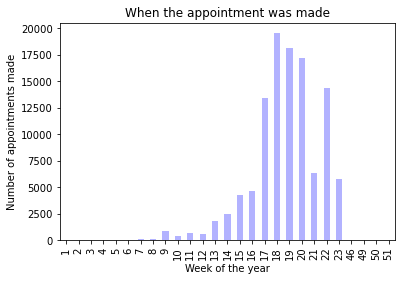

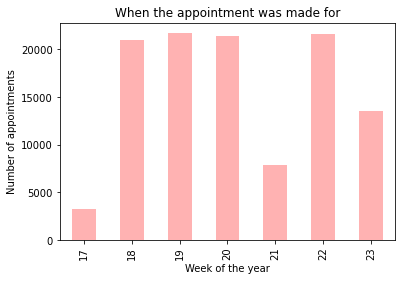

count    110526.000000
mean         10.183794
std          15.255034
min          -6.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: days_wait, dtype: float64


In [17]:
# Turning the datetime informaiton into the correct form
# We want the datetime the appointment was made so we can order the data like
# that at some point
# we want the Day datetime so we can calculate number of days between them easily
df['AppointMade'] = df['AppointMade'].values.astype('datetime64[s]')
df['AppointMadeD'] = df['AppointMade'].values.astype('datetime64[D]')
df['AppointFor'] = df['AppointFor'].values.astype('datetime64[D]')

# grouping the appointments into the week of the year it was made and counting
# the number of instances
df.groupby(df["AppointMade"].dt.week)["AppointMade"].count().plot(kind="bar", color='b', alpha=0.3)
plt.title('When the appointment was made')
plt.xlabel('Week of the year')
plt.ylabel('Number of appointments made')
plt.show()

# grouping the appointments into the week of the year it was made for and counting
# the number of instances
df.groupby(df["AppointFor"].dt.week)["AppointFor"].count().plot(kind="bar", color='r', alpha=0.3)
plt.title('When the appointment was made for')
plt.xlabel('Week of the year')
plt.ylabel('Number of appointments')
plt.show()

# Calculating the number of days inbetween the appointment and when it was made
# Have to convert it into an integer for later use
df['days_wait'] = (df['AppointFor'] - df['AppointMadeD'])  / np.timedelta64(1, 'D')
df['days_wait'] = df['days_wait'].astype(int)
print(df['days_wait'].describe())

We can see that our data comees from quite a restricted time-span. We have all the appointments for seven weeks and when they were made. Many were made some time before the seven week window but most were made during it (short waiting times). This means that in many cases, by the time the appointment was made, there may have already been data on that patient. How many other appointments they have made and how many they have missed.

Number of days being cut as the appointment was before it was made... - 5


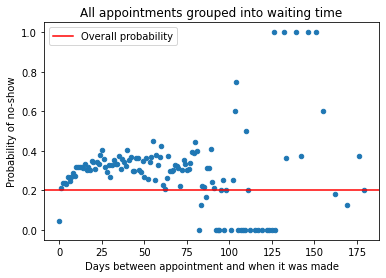

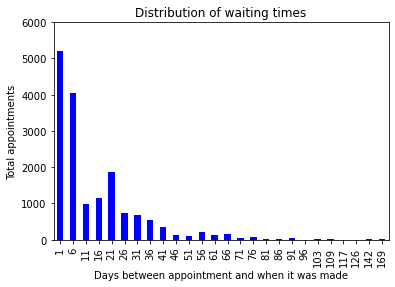

In [18]:
print('Number of days being cut as the appointment was before it was made... ', 
      df[df['days_wait'].astype(int) < 0].shape[0])
# Removing all instances where the appointment was before the day it was made
# These are obviously typos and should be removed
df = df[df['days_wait'] >= 0]

# GRouping all appointments into how many days the patient had to wait
# and calculating a probability of showing up for each 'number of days wait'
df_days = pd.concat([df.groupby('days_wait')['No'].sum(), df.groupby('days_wait')['Yes'].sum()], axis=1)
df_days['Total'] = df_days['No'] + df_days['Yes']
df_days['Probability of no-show'] = df_days['Yes'] / df_days['Total']
df_days.reset_index(inplace=True)

# Plotting the probabilities of no-show for each days_waited value
df_days.plot(kind='scatter', x='days_wait', y='Probability of no-show')
plt.axhline(noshow_prob, c='r', label='Overall probability')
plt.legend()
plt.title('All appointments grouped into waiting time')
plt.xlabel('Days between appointment and when it was made')
plt.show()

# For making a distribution of waiting times
df_days_plot = df.groupby("days_wait")["days_wait"].count()
# Misses out the first data point as it is so much higher
# and then shows every 5th or there are too many bars and can't read xaxis
df_days_plot.iloc[1::5].plot(kind="bar", color='b')
plt.ylim(0,6000)
plt.title('Distribution of waiting times')
plt.xlabel('Days between appointment and when it was made')
plt.ylabel('Total appointments')
plt.show()

There seems to be a polynomial relationship here but it is made not clear by the high wait time data points as there are not enough samples at these points. We will combine all values above 75 at 75.

We also see that 0 days has a clearly different relationship than the rest and so this deserves its own weighting. Giving instances a 1 for same day appointment and 0 for not same day will introduce a bias for the same day instances.

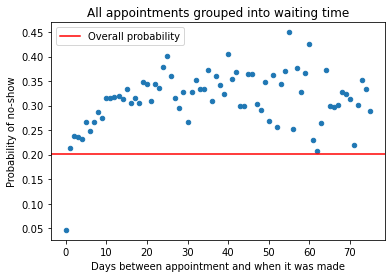

In [19]:
# Creating a feature for if the appointment was made on the same day
df['same_day'] = np.NaN
df.loc[df['days_wait'] == 0, 'same_day'] = 1
df['same_day'].fillna(0, inplace=True)

# capping the wait time at 75. above that there aren't enough samples for
# reliable data
max_days = 75
df['days_wait'][df['days_wait'] >= max_days] = max_days

# Grouping all appointments into number of days waiting and caluclaing the 
# probability of no-show
df_days = pd.concat([df.groupby('days_wait')['No'].sum(), df.groupby('days_wait')['Yes'].sum()], axis=1)
df_days['Total'] = df_days['No'] + df_days['Yes']
df_days['Probability of no-show'] = df_days['Yes'] / df_days['Total']
df_days.reset_index(inplace=True)

# Plotting the probabilities
df_days.plot(kind='scatter', x='days_wait', y='Probability of no-show')
plt.axhline(noshow_prob, c='r', label='Overall probability')
plt.legend()
plt.title('All appointments grouped into waiting time')
plt.xlabel('Days between appointment and when it was made')
plt.show()

The 0 days (or same day appointment) instances clearly do not fit the trent of the rest of the wait times. It is shifted down and so can be captured with a binary category. 0 will represent the rest of the wait times and 1 will represent the 0 days wait time. The 1 will recieve a waiting that will shift the 0 days predction down by the appropriate amount.

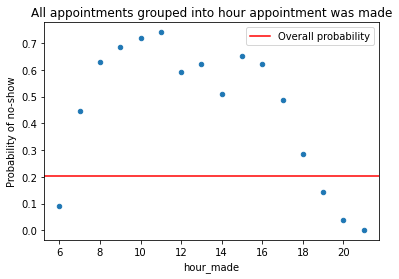

In [20]:
# Extracting the hour of the day form the appointment made time
df['hour_made'] = df['AppointMade'].dt.hour

# GRouping all appointments into the time of day it was made and 
# calculating probability of no-show for each value
df_hour = pd.concat([df.groupby('hour_made')['No'].sum(), df.groupby('hour_made')['Yes'].sum()], axis=1)
df_hour['Total'] = df_days['No'] + df_hour['Yes']
df_hour['Probability of no-show'] = df_hour['Yes'] / df_hour['Total']
df_hour.reset_index(inplace=True)

df_hour.plot(kind='scatter', x='hour_made', y='Probability of no-show')
plt.axhline(noshow_prob, c='r', label='Overall probability')
plt.legend()
plt.title('All appointments grouped into hour appointment was made')
plt.show()

So there is a relationship here and it will certainly need polynomial terms to capture it. There is a clear correlation with the work day here, with even a dip during lunch time. This suggests to me that people who make appointments during work hours are probably less likely to be working and could therefore be a little more unreliable. This might mean we need to treat weekdays and weekends separately.

         Yes       No  Probability of no-show
Mon   4561.0  18523.0                0.197583
Tue   5290.0  20877.0                0.202163
Wed   4876.0  19383.0                0.200998
Thur  3699.0  14373.0                0.204681
Fri   3887.0  15028.0                0.205498
Sat      1.0     23.0                0.041667


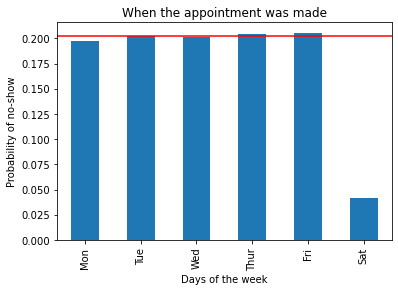

         Yes       No  Probability of no-show
Mon   4689.0  18024.0                0.206446
Tue   5150.0  20488.0                0.200874
Wed   5092.0  20774.0                0.196861
Thur  3337.0  13909.0                0.193494
Fri   4037.0  14982.0                0.212261
Sat      9.0     30.0                0.230769


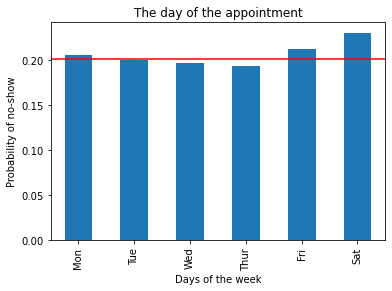

In [21]:
# To replace 0,2,3,4,5 with the actual days of the week
# there are no appointments on or made on sunday
week_days = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat']

#  GEtting the day of he week the appointment was made form the date
df['dow_made'] = df['AppointMade'].dt.dayofweek
# Grouping all appointments into the day of the week it was made and 
# calculating probability of no-show for each value
df_dow = pd.concat((df.groupby('dow_made')['Yes'].sum(), df.groupby('dow_made')['No'].sum()), axis=1)
df_dow['Probability of no-show'] = df_dow['Yes'] / (df_dow['Yes'] + df_dow['No'])
df_dow.index = week_days

print(df_dow.head(7))
df_dow['Probability of no-show'].plot(kind='bar')
plt.axhline(noshow_prob, c='r', label='Overall probability')
plt.xlabel('Days of the week')
plt.ylabel('Probability of no-show')
plt.title('When the appointment was made')
plt.show()

# Grouping all appointments into the day of the week it was made FOR and 
# calculating probability of no-show for each value
df['dow_for'] = df['AppointFor'].dt.dayofweek
df_dowf = pd.concat((df.groupby('dow_for')['Yes'].sum(), df.groupby('dow_for')['No'].sum()), axis=1)
df_dowf['Probability of no-show'] = df_dowf['Yes'] / (df_dowf['Yes'] + df_dowf['No'])
df_dowf.index = week_days

print(df_dowf.head(7))
df_dowf['Probability of no-show'].plot(kind='bar')
plt.axhline(noshow_prob, c='r', label='Overall probability')
plt.xlabel('Days of the week')
plt.ylabel('Probability of no-show')
plt.title('The day of the appointment')
plt.show()

We have so few weekend bookings and appointments that we don't need to worry about it. This means time of day will entirely capture whether it is during work time or not and we don't need to separate the time for weekend and weekday.

### Individual patient records
Investigating patients that have multiple appointments.

In [22]:
# This function looks at all appointments made before the current appointFor date
# and where the patient number is the same as at the current row
# and count the number of missed appointments
def count_missed_apts_before_now(row, df):
    subdf = df.query("AppointFor<@row.AppointMade and\
                     `No-show`=='Yes' and PatientId==@row.PatientId")
    return len(subdf)

# Sorting by appointment made date so we can get rolling counts
df.sort_values(by='AppointMade', inplace=True)
# Calculating how many time the patient has made an appointment before
df['book_count'] = df.groupby('PatientId').cumcount()
# Calculating the number of times a patient has missed an appointment before making the current one
t3 = time.time()
df['miss_count'] = df.apply(count_missed_apts_before_now, axis=1, args = (df,))
t4 = time.time()
miss_count_t = t4-t3
print(f'miss count column calculated in {miss_count_t}')

miss count column calculated in 540.3125910758972


These are two features which are a little hard to justify for a normal kaggle/machine learning project. Firstly because the data is only between a small timing window, i doubt these features will work particularly effectively. We will have many patients that have had multiple booked and missed appointments but which fall outside of our range. This will affect the chance of no-show but won't be captured by the model. Secondly, in order for them to work at all, I will have to include some cross contamination between the test and train datasets. Without doing this, the test set would be too small for miss_count to build up any at all. However, I chose to include them because if this was a real world scenario and not a kaggle dataset, I definitely would include it. It would be key information so I have decided to build a model that I would be happy to use in a real world situation (rather than one which outperforms on this problem set).

It should be noted that I can find no way to vectorise the miss_count column and so it takes quite some time. This would not, in its current form, be scalable to much larger datasets.

# Feature selection and engineering

Lets start by clearing out some columns we wont be using and creating those polynomial features.

In [23]:
# These additional date categories are of no use after processing the info we need
df.drop(['dow_made', 'dow_for', 'AppointFor', 'AppointMade', 'AppointMadeD'], 
        axis=1, inplace=True)
# These are the results categories but in the wrong form
df.drop(['No', 'No-show'], axis=1, inplace=True)
# These two categories showed no correlation with showing up for an appointment
df.drop(['Gender', 'Alcoholism'], inplace=True, axis=1)
# handicap may have some vlaue and would need to be treated as dummy cols
# but there may be some cross-correlation with age
df.drop('Handicap', axis=1, inplace=True)
# These categories showed a weak correlation so could tell us something, but there
# was considerable cross correlation with Age
df.drop(['Scholarship', 'Hypertension', 'Diabetes'], inplace=True, axis = 1)
# No longer need Patient ID as we have all the information on repeat patients
df.drop('PatientId', inplace=True, axis=1)

df['Age^2'] = df['Age'] ** 2
df['Age^3'] = df['Age'] ** 3
df['hour_made^2'] = df['hour_made'] ** 2
df['hour_made^3'] = df['hour_made'] ** 3
# Only going up to squared for days_wait as the relationship seemed to be more simple
df['days_wait^2'] = df['days_wait'] ** 2

print(df.head())

               Age  Neighbourhood  SMS_received  Yes  days_wait  same_day  \
AppointmentID                                                               
5030230         51    RESISTÊNCIA             1    0         75       0.0   
5122866         34     VILA RUBIM             1    1         75       0.0   
5134197         27  SÃO CRISTÓVÃO             1    1         75       0.0   
5134220         48        MARUÍPE             1    0         75       0.0   
5134223         80  SÃO CRISTÓVÃO             1    0         75       0.0   

               hour_made  book_count  miss_count  Age^2   Age^3  hour_made^2  \
AppointmentID                                                                  
5030230                7           0           0   2601  132651           49   
5122866                8           0           0   1156   39304           64   
5134197               10           0           0    729   19683          100   
5134220               10           0           0   2304  110

In [24]:
# These will be added to the dataframe during feature engineering
dum_neigh = pd.get_dummies(df['Neighbourhood'])
# neigh_keep is my list of statistically significant neighbourhoods
dum_neigh = dum_neigh[neigh_keep]
dum_neigh.head()

df = pd.concat((df, dum_neigh), axis = 1)
df.drop('Neighbourhood', axis=1, inplace=True)
print(df.columns.tolist())

['Age', 'SMS_received', 'Yes', 'days_wait', 'same_day', 'hour_made', 'book_count', 'miss_count', 'Age^2', 'Age^3', 'hour_made^2', 'hour_made^3', 'days_wait^2', 'JARDIM CAMBURI', 'JARDIM DA PENHA', 'ITARARÉ', 'TABUAZEIRO', 'SANTA MARTHA', 'JESUS DE NAZARETH', 'SANTO ANTÔNIO', 'CARATOÍRA', 'JABOUR', 'ILHA DO PRÍNCIPE', 'NOVA PALESTINA', 'ANDORINHAS', 'GURIGICA', 'MARUÍPE', 'FORTE SÃO JOÃO', 'REDENÇÃO', 'JOANA D´ARC', 'CONSOLAÇÃO', 'PRAIA DO SUÁ', 'SANTOS DUMONT', 'VILA RUBIM', 'DO QUADRO', 'REPÚBLICA', 'MATA DA PRAIA', 'DO CABRAL', 'SANTA CLARA', 'SOLON BORGES', 'SANTA CECÍLIA', 'MÁRIO CYPRESTE', 'DE LOURDES']


Here we have used the list of statistically significant neighbourhoods we previously calculated. I have added the dummy columns to the df at this point (and not earlier) as we drop some columns between then so we want the dummies to match with the df.

In [25]:
# Splitting the dataframe into features and the target
X = df.loc[:, df.columns != 'Yes']
y = df.loc[:, df.columns == 'Yes']

# Splitting the dataframe into a train dataset and a test dataset
# random state used so its the same split each time. this aids with comparisons
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
features = X_train.columns

Simply splitting the data into a test and train so that we can make sure our model doesn't over-paramterise on the train dataset. There is no point in it predicting the train data set perfectly if it causes inaccuracies predicting new data.

In [26]:
# substantiating an isntance of the SMOTE object
os = SMOTE(random_state=0)

# Adding a lot of new dummy data for no-show = Yes to even out the Yes and No
os_data_X, os_data_y = os.fit_sample(X_train, y_train)
# Giving the new dataframes the old names
os_data_X = pd.DataFrame(data=os_data_X, columns=features )
os_data_y = pd.DataFrame(data=os_data_y, columns=['Yes'])

print('old number of instances is ', X_train.shape[0])
print('old number of no shows is ', y_train['Yes'].sum())
print('proportions of no shows is ', y_train['Yes'].sum() / X_train.shape[0], '\n\n')

print('new number of instances is ', os_data_X.shape[0])
print('new number of no shows is ', os_data_y['Yes'].sum())
print('proportions of no shows is ', os_data_y['Yes'].sum() / os_data_X.shape[0])

old number of instances is  88416
old number of no shows is  17896
proportions of no shows is  0.20240680419833515 


new number of instances is  141040
new number of no shows is  70520
proportions of no shows is  0.5


Here we have padded our data with new 'no-shows' in order to balance the data. This is done by creating more instances with similar featue values as the ones we already have. It is necessary to balance the data before we start the model or the model will struggle to predict the category with fewer instances.

Next we do a simple normalization of the features which have a wide range to aid conversion. It helps the model for all features to be in a similar range. We do this after the test/train split in order to make sure no information from the test dataset leaks into the train dataset.

In [27]:
# These are all fetures which go way above 1. They need to be brough back to a 
# similar scale as our binary features
to_normalize = ['Age', 'Age^2', 'Age^3', 'hour_made', 'hour_made^2', 'hour_made^3', 
                'days_wait', 'days_wait^2', 'book_count', 'miss_count']

# Normalizing very simply by just dividing be the range
for cat in to_normalize:
    os_data_X[cat] = os_data_X[cat] / (os_data_X[cat].max() - os_data_X[cat].min())
    # Done separately so there is no cross-contamination between test and train
    X_test[cat] = X_test[cat] / (X_test[cat].max() - X_test[cat].min())

print(os_data_X.describe())

                 Age   SMS_received      days_wait       same_day  \
count  141040.000000  141040.000000  141040.000000  141040.000000   
mean        0.424058       0.286096       0.157595       0.247475   
std         0.266919       0.451936       0.199001       0.425962   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.200000       0.000000       0.013333       0.000000   
50%         0.411765       0.000000       0.080000       0.000000   
75%         0.635294       1.000000       0.240000       0.414636   
max         1.000000       1.000000       1.000000       1.000000   

           hour_made     book_count     miss_count          Age^2  \
count  141040.000000  141040.000000  141040.000000  141040.000000   
mean        0.725766       0.011932       0.009634       0.251085   
std         0.214188       0.037265       0.037557       0.249389   
min         0.400000       0.000000       0.000000       0.000000   
25%         0.533333       0.0000

In [28]:
# A logisitc regression object
logreg = LogisticRegression()
# The recursive feature elimination object
rfe = RFE(logreg, 20)

X = os_data_X.values
y = os_data_y.values

# This is our list of features before feature filtering
start_feats = X_train.columns.tolist()

# Using the log regression object to test the importance of each feature in turn
rfe = rfe.fit(X, y)
for ii, cat in enumerate(start_feats):
    print(cat, ' - ', rfe.support_[ii])

Age  -  True
SMS_received  -  False
days_wait  -  False
same_day  -  True
hour_made  -  True
book_count  -  True
miss_count  -  True
Age^2  -  True
Age^3  -  True
hour_made^2  -  True
hour_made^3  -  True
days_wait^2  -  False
JARDIM CAMBURI  -  False
JARDIM DA PENHA  -  True
ITARARÉ  -  False
TABUAZEIRO  -  True
SANTA MARTHA  -  False
JESUS DE NAZARETH  -  False
SANTO ANTÔNIO  -  False
CARATOÍRA  -  False
JABOUR  -  True
ILHA DO PRÍNCIPE  -  False
NOVA PALESTINA  -  True
ANDORINHAS  -  False
GURIGICA  -  False
MARUÍPE  -  False
FORTE SÃO JOÃO  -  True
REDENÇÃO  -  False
JOANA D´ARC  -  True
CONSOLAÇÃO  -  False
PRAIA DO SUÁ  -  False
SANTOS DUMONT  -  False
VILA RUBIM  -  True
DO QUADRO  -  False
REPÚBLICA  -  True
MATA DA PRAIA  -  True
DO CABRAL  -  False
SANTA CLARA  -  False
SOLON BORGES  -  True
SANTA CECÍLIA  -  False
MÁRIO CYPRESTE  -  False
DE LOURDES  -  True


This goes through our list of features and drops one each time to test it's significance. It can be used to drop features which have less significance. True should be important and False less important.

In [29]:
# Tried to remove all features which do not have such a strong influence but ended up
# making the model worse. We will check the statistical signigicance of
# each feature now
#feats2 = [x for x, y in zip(start_feats, rfe.support_) if y == True]
feats2 = start_feats
print(feats2)

X = os_data_X.loc[:, os_data_X.columns.isin(feats2)].values
y = os_data_y.values

# Looking at the statistical significance of each of our features in a log model
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

['Age', 'SMS_received', 'days_wait', 'same_day', 'hour_made', 'book_count', 'miss_count', 'Age^2', 'Age^3', 'hour_made^2', 'hour_made^3', 'days_wait^2', 'JARDIM CAMBURI', 'JARDIM DA PENHA', 'ITARARÉ', 'TABUAZEIRO', 'SANTA MARTHA', 'JESUS DE NAZARETH', 'SANTO ANTÔNIO', 'CARATOÍRA', 'JABOUR', 'ILHA DO PRÍNCIPE', 'NOVA PALESTINA', 'ANDORINHAS', 'GURIGICA', 'MARUÍPE', 'FORTE SÃO JOÃO', 'REDENÇÃO', 'JOANA D´ARC', 'CONSOLAÇÃO', 'PRAIA DO SUÁ', 'SANTOS DUMONT', 'VILA RUBIM', 'DO QUADRO', 'REPÚBLICA', 'MATA DA PRAIA', 'DO CABRAL', 'SANTA CLARA', 'SOLON BORGES', 'SANTA CECÍLIA', 'MÁRIO CYPRESTE', 'DE LOURDES']
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
                       Results: Logit
Model:              Logit            Pseudo R-squared: inf   
Dependent Variable: y                AIC:              inf   
Date:               2020-10-27 12:18 BIC:              inf   
No. Observations:   141040           Log-Likelihood:   -inf  
Df Model

I tested dropping the features that the RFE method suggested were less important but got a significantly worse end model.

The logmodel test for significant features gives a small p-value for all by the 'hour_made^2' feature.

In [30]:
# Removing the 'hour_made^2' feature
feats2 = [x for x in feats2 if x != 'hour_made^2']

X = os_data_X.loc[:, os_data_X.columns.isin(feats2)].values
y = os_data_y.values

# The object we will use for our final model
logreg = LogisticRegression()
# Making the model
logreg.fit(X, y)

# Extracting only our new filtered feature dataset
X_test = X_test[feats2]
# Making our predictions on the test dataset
y_pred = logreg.predict(X_test)

Logistic regression is used to create a model which can predict if a patient will show up for a medical appointmnet or not. y_pred is my predicitons for the test dataset

# Model evaluation

In [31]:
# This is how well the model predicts the 'Yes' column whether there was a no-show
score = logreg.score(X_test, y_test)
print('Accuracy when tested on the test set - ', score)

# This is to show how often we got true/negative, true/positive, false/negative and false/positive
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

Accuracy when tested on the test set -  0.6713865641257634
[[12507  5180]
 [ 2084  2334]]


This overall accuracy is not high. In fact it would be higher (~80%) if we simply predicted every instance to be a show-up. This would however, give us no ability to predict no-shows.

The confusion matrix tells us: 
 - we have correctly predicted a show-up 12556 times (true positive)
 - we have correctly predicted a no-show 2310 times (true negative)
 - we have failed to predict a show-up 5131 times (false negative)
 - we have failed to predict a no-show 2108 times (false positive)

In [32]:
print('ratio of predicted noshows to show-ups -',y_pred.sum() / len(y_pred))
print(classification_report(y_test, y_pred))

ratio of predicted noshows to show-ups - 0.33992309432255147
              precision    recall  f1-score   support

           0       0.86      0.71      0.77     17687
           1       0.31      0.53      0.39      4418

    accuracy                           0.67     22105
   macro avg       0.58      0.62      0.58     22105
weighted avg       0.75      0.67      0.70     22105



The precision is $\frac{true_{pos}}{true_{pos} + false_{pos}}$ or the ability of the model to not miss any of this category.

The recall is $\frac{true_{pos}}{true_{pos} + false_{neg}}$ or the ability of the model to accurately get all of the positives for this category

Category 0 is a 'show up'
Category 1 is a 'no-show'

A recall of 0.5 for '1' means that we can predict no-shows with 52% accuracy which is very useful relative to how we started, only being able to predict all are no-shows giving an overall accuracy of ~20%. The model is obviously useless for 'predicting a show up' as we could just assume they will all show up and get it right 100% of the time (with an overall accuracy of ~80%) and my model predicts this only 71% of the time. But predicting them to show up isn't interesting. We want to find the people who wont show up.

A model which does not adress the imbalanced nature of the model will simply predict all show-ups. This will give very good metrics for show ups and terrible for no-shows.

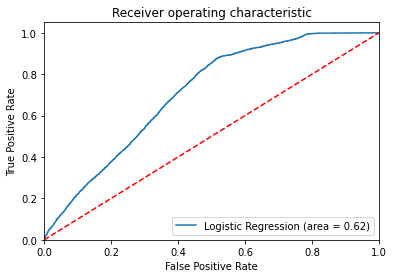

In [33]:
# Calculating the false positive and true positive rates
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (area = {logit_roc_auc:.2f})')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

The ROC curve moves away from the central line to the top left a reasonable amount indicating a good model.

Overall the model seems to be reasonably effective but still lacking. Probably there are some other features available but none that I could find in the data given. Certainly trying some other algorithms might be effective but I wanted to test logistic regression here.